### Домашнее задание №5 ###
<ol>
    <li>Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).
    <li>И затем обучить Модель на выбор из segmentation_models_pytorch
    <li>(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.
</ol>

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import cv2
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
        self.softmax = nn.Softmax()
    
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=out_channels),
                              nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=out_channels))
        return block


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.contracting_11(X) # [-1, 64, 256, 256]
        x2 = self.contracting_12(x1) # [-1, 64, 128, 128]
        x3 = self.contracting_21(x2) # [-1, 128, 128, 128]
        x4 = self.contracting_22(x3) # [-1, 128, 64, 64]
        x5 = self.contracting_31(x4) # [-1, 256, 64, 64]
        x6 = self.contracting_32(x5) # [-1, 256, 32, 32]
        x7 = self.contracting_41(x6) # [-1, 512, 32, 32]
        x8 = self.contracting_42(x7) # [-1, 512, 16, 16]
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        z = self.crop_tensor(x, x7)
        x = self.expansive_12(torch.cat((x, z), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.expansive_21(x) # [-1, 256, 64, 64]
        x5 = self.crop_tensor(x, x5)
        x = self.expansive_22(torch.cat((x, x5), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.expansive_31(x) # [-1, 128, 128, 128]
        x3 = self.crop_tensor(x, x3)
        x = self.expansive_32(torch.cat((x, x3), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.expansive_41(x) # [-1, 64, 256, 256]
        x1 = self.crop_tensor(x, x1)
        x = self.expansive_42(torch.cat((x, x1), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output = self.output(x) # [-1, num_classes, 256, 256]
        
        output = self.softmax(output)

        return output
    
   
    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        
        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

In [3]:
#labels = np.unique(plt.imread('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000001.png')[:,:,0]*255)
labels = [ 'Unlabeled','Lips']
image_path = 'set-lipstick-original\\720p\\'
mask_path = 'set-lipstick-original\\mask\\'
save_path = 'new_image\\'

In [4]:
#os.mkdir('new_image')

In [5]:
plt.imread(image_path+'image00000001.jpg')[:,:,0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 254, ..., 255, 255, 255],
       [254, 254, 254, ..., 255, 255, 255],
       ...,
       [ 32,  32,  32, ...,  63,  63,  63],
       [ 32,  32,  32, ...,  60,  61,  61],
       [ 32,  32,  32, ...,  58,  59,  59]], dtype=uint8)

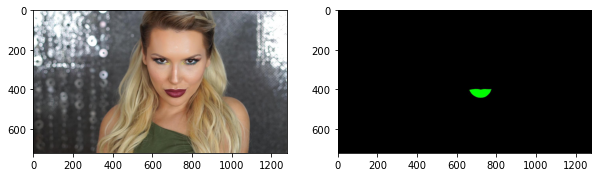

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10, 10))
ax[0].imshow(plt.imread(image_path+'image00000001.jpg'))
ax[1].imshow(plt.imread(mask_path+'mask00000001.png'))
plt.show()


for i in range(78):
    mask = plt.imread('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000001.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(labels[i])
    plt.imshow(mask)
    plt.show()

In [7]:
df = pd.read_csv('set-lipstick-original/list.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
df = pd.DataFrame({'cameraRGB':  df['filename'],
                    'cameraSeg': df['mask']})

In [9]:
df.head(5)

,cameraRGB,cameraSeg
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [10]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28594 entries, 0 to 28593
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cameraRGB  28594 non-null  object
 1   cameraSeg  28594 non-null  object
dtypes: object(2)
memory usage: 670.2+ KB


In [11]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('./set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            cameraRGB.append(name)
        elif 'mask' in f:
            cameraSeg.append(name)
        else:
            break

In [12]:
cameraSeg = sorted(cameraSeg)
cameraRGB = sorted(cameraRGB)

In [13]:
len(cameraSeg),len(cameraRGB)

(28540, 28594)

In [14]:
mask_list = sorted([i.name for i in Path('./set-lipstick-original/mask/').iterdir()])

In [15]:
str(mask_list[1])

'mask00000002.png'

In [16]:
df = df.loc[df['cameraSeg'].isin([str(i) for i in mask_list])]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cameraRGB  28540 non-null  object
 1   cameraSeg  28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [17]:
def mask_monochrome(x):
    if (os.path.exists(os.path.join(save_path, x)) == False):
        mask = cv2.imread(os.path.join(mask_path, x), cv2.IMREAD_GRAYSCALE)
        (thresh, mask_binary) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        cv2.imwrite(os.path.join(save_path, x), mask_binary)
    return os.path.join(save_path, x)

In [18]:
#StopCode

In [19]:
img = []
new_mask = []
for index, row in df.iterrows():
    img_path = os.path.join(image_path, row['cameraRGB'])
    new_mask_path = mask_monochrome(row['cameraSeg'])
    img.append(img_path)
    new_mask.append(new_mask_path)
df['cameraRGB'] = img
df['cameraSeg'] = new_mask

In [20]:
df.head()

,cameraRGB,cameraSeg
0,set-lipstick-original\720p\image00000001.jpg,new_image\mask00000001.png
1,set-lipstick-original\720p\image00000002.jpg,new_image\mask00000002.png
2,set-lipstick-original\720p\image00000003.jpg,new_image\mask00000003.png
3,set-lipstick-original\720p\image00000004.jpg,new_image\mask00000004.png
4,set-lipstick-original\720p\image00000005.jpg,new_image\mask00000005.png


In [21]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
        self.class_values = [labels.index(cls) for cls in labels]
        
    def __getitem__(self, index):
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256,256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
        mask = np.asarray(plt.imread(self.label_arr[index]))[:,:]*255

        # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')
        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)
        # Размерность каналов на передний план
        mask = mask.permute(2,0,1)
        
        # делаем ресайз маски на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        # unsqueeze - меняет размерность img c (256, 256, 3) -> (1, 256, 256, 3),
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        mask=mask.squeeze(0).squeeze(0)
        
        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df,test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [23]:
X_train.iloc[:,1]

0        new_image\mask00004656.png
1        new_image\mask00028031.png
2        new_image\mask00023264.png
3        new_image\mask00012604.png
4        new_image\mask00000091.png
                    ...            
19973    new_image\mask00027889.png
19974    new_image\mask00027586.png
19975    new_image\mask00000910.png
19976    new_image\mask00007185.png
19977    new_image\mask00022498.png
Name: cameraSeg, Length: 19978, dtype: object

In [24]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=5,shuffle=False)

In [25]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std())

tensor(0.6601) tensor(0.2990)


In [26]:
learning_rate = 0.0001
epochs = 5

In [27]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [28]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score
    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
device

device(type='cpu')

In [31]:
model = UNet(num_classes=2).to(device)

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion=SoftDiceLoss()

In [33]:
# The training loop
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

5 epochs, 2498 total_steps per epoch


In [34]:
step_losses = []
epoch_losses = []

In [35]:
labels

['Unlabeled', 'Lips']

In [36]:
train_data_loader.dataset.data_info

,cameraRGB,cameraSeg
0,set-lipstick-original\720p\image00004656.jpg,new_image\mask00004656.png
1,set-lipstick-original\720p\image00028031.jpg,new_image\mask00028031.png
2,set-lipstick-original\720p\image00023264.jpg,new_image\mask00023264.png
3,set-lipstick-original\720p\image00012604.jpg,new_image\mask00012604.png
4,set-lipstick-original\720p\image00000091.jpg,new_image\mask00000091.png
...,...,...
19973,set-lipstick-original\720p\image00027889.jpg,new_image\mask00027889.png
19974,set-lipstick-original\720p\image00027586.jpg,new_image\mask00027586.png
19975,set-lipstick-original\720p\image00000910.jpg,new_image\mask00000910.png
19976,set-lipstick-original\720p\image00007185.jpg,new_image\mask00007185.png


In [ ]:

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, (inputs, labels) in enumerate(train_data_loader):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        #print(i,len(data))
        inputs = inputs.to(device)
        labels = labels.to(device)
  
        # zero the parameter gradients
        optimizer.zero_grad()
      
      
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')